In [1]:
"""
In this nb, we are forecasting Time-Series with a Stateful LSTM(Long Short Term Memory) Model. LSTM has better
memory and thus it can be used for longer window_size. 

In LSTM cell, we have Input Gate(Simple RNN Cell), Forget Gate(Dense+Sigmoid), Output Gate(Dense+Sigmoid).
Plus, two state vectors, Long Term State Vector and Short Term one. We are keeping this Stateful.

"""

# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

# A function to plot time-series. This will be called finally when complete series is built
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end],series[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
# Function to create a trend
def trend(time,slope=0):
    return slope*time

# Creating a time series
time = np.arange(4*365+1)
baseline = 10 #Base value for trend 

# Function which creates a random pattern. This pattern will be repeated to get a seasonal pattern
def seasonal_pattern(seasonal_time):
    return np.where(seasonal_time < 0.4,
                    1/np.exp(3*seasonal_time),
                    np.cos(seasonal_time*2*np.pi))

# Function to repeat seasonal pattern
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

# Function to create white noise. seed parameter here is used by random number generator as a base to create
# random number. When it is None, rnd will use system time as seed. But, if we give some constant value like 42,
# then every time same noise will be generated. Thus, to get different noise everytime keep seed as None even 
# while calling the function
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Creating Seasonality 
amplitude = 50
series = seasonality(time,period=365,amplitude=amplitude) + baseline

# Creating White Noise
noise_level = 5
noise = white_noise(time,noise_level)

# Creating seasonality with trend
slope = 0.05
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)

# Finally plotting complete time-series
series += noise
plt.figure(figsize=(10,10))
plot_series(time,series,label="Time-Series")

# Creating Training and Validation data
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Function to apply our model to series(This will be validation series)
def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [4]:
# No Shuffling of data- Continuous data is needed
# Shifting by window_size
# Batch contains only single window, training becomes slow
def sequential_window_dataset(series,window_size,batch_size=32):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
    dataset = dataset.batch(1).prefetch(1)
    return dataset

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

Epoch 1/100
33/33 [==============================] - 7s 213ms/step - loss: 89.5783 - mae: 90.0778
Epoch 2/100
33/33 [==============================] - 1s 36ms/step - loss: 84.3714 - mae: 85.0187
Epoch 3/100
33/33 [==============================] - 1s 37ms/step - loss: 78.4908 - mae: 79.1106
Epoch 4/100
33/33 [==============================] - 1s 36ms/step - loss: 72.0873 - mae: 72.6798
Epoch 5/100
33/33 [==============================] - 1s 37ms/step - loss: 65.1667 - mae: 65.7303
Epoch 6/100
33/33 [==============================] - 1s 37ms/step - loss: 58.3467 - mae: 58.8771
Epoch 7/100
33/33 [==============================] - 1s 37ms/step - loss: 51.2804 - mae: 51.7668
Epoch 8/100
33/33 [==============================] - 1s 37ms/step - loss: 43.7789 - mae: 44.2179
Epoch 9/100
33/33 [==============================] - 1s 37ms/step - loss: 35.9023 - mae: 36.2861
Epoch 10/100
33/33 [==============================] - 1s 37ms/step - loss: 27.9978 - mae: 28.3178
Epoch 11/100
33/33 [========

33/33 [==============================] - 2s 50ms/step - loss: 37.7020 - mae: 37.8437
Epoch 85/100
33/33 [==============================] - 2s 49ms/step - loss: 18.4107 - mae: 18.4437
Epoch 86/100
33/33 [==============================] - 1s 40ms/step - loss: 23.4252 - mae: 24.7029
Epoch 87/100
33/33 [==============================] - 1s 32ms/step - loss: 42.7659 - mae: 42.1697
Epoch 88/100
33/33 [==============================] - 2s 75ms/step - loss: 23.6425 - mae: 23.8102
Epoch 89/100
33/33 [==============================] - 2s 60ms/step - loss: 25.2132 - mae: 25.0038
Epoch 90/100
33/33 [==============================] - 3s 84ms/step - loss: 18.8089 - mae: 19.1178
Epoch 91/100
33/33 [==============================] - 2s 58ms/step - loss: 31.3585 - mae: 32.4108
Epoch 92/100
33/33 [==============================] - 2s 56ms/step - loss: 40.3359 - mae: 41.2475
Epoch 93/100
33/33 [==============================] - 2s 50ms/step - loss: 36.8811 - mae: 37.9237
Epoch 94/100
33/33 [=============

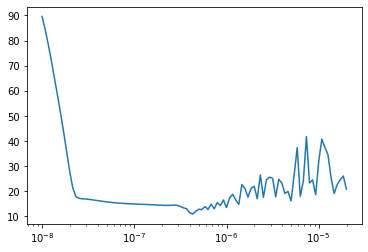

In [6]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = sequential_window_dataset(x_train,window_size)

# Stateful LSTM Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
# stateful = True makes sure that the state of previous batch goes to the next one
model = tf.keras.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 30 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/30))
reset_state = ResetStatesCallback()

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_state])

plt.semilogx(history.history['lr'],history.history['loss'])

In [8]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = sequential_window_dataset(x_train,window_size)
valid_set = sequential_window_dataset(x_valid,window_size)

# Simple RNN Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
# stateful = True makes sure that the state of previous batch goes to the next one
model = tf.keras.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# Stops training if metric stays same for 50 epochs on valid_set
early_stopper = keras.callbacks.EarlyStopping(patience=50)
reset_state = ResetStatesCallback()

# Saves the best model(model with best parameters) as "my_checkpoint.h5" so that we can load this model at end
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only = True)

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper,reset_state])

Epoch 1/100
33/33 [==============================] - 9s 273ms/step - loss: 75.9665 - mae: 76.4659 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
33/33 [==============================] - 1s 43ms/step - loss: 36.9249 - mae: 32.3794 - val_loss: 30.2576 - val_mae: 30.7565
Epoch 3/100
33/33 [==============================] - 1s 40ms/step - loss: 20.2344 - mae: 18.5874 - val_loss: 26.0320 - val_mae: 26.5316
Epoch 4/100
33/33 [==============================] - 1s 40ms/step - loss: 19.9341 - mae: 18.6198 - val_loss: 26.9884 - val_mae: 27.4878
Epoch 5/100
33/33 [==============================] - 1s 41ms/step - loss: 18.5059 - mae: 17.5903 - val_loss: 25.9884 - val_mae: 26.4878
Epoch 6/100
33/33 [==============================] - 1s 41ms/step - loss: 17.9603 - mae: 17.2585 - val_loss: 25.8133 - val_mae: 26.3118
Epoch 7/100
33/33 [==============================] - 1s 42ms/step - loss: 17.3058 - mae: 16.7980 - val_loss: 25.4083 - val_mae: 25.9069
Epoch 8/100
33/33 [======================

Epoch 61/100
33/33 [==============================] - 1s 42ms/step - loss: 11.3057 - mae: 10.6803 - val_loss: 12.4739 - val_mae: 12.9646
Epoch 62/100
33/33 [==============================] - 2s 46ms/step - loss: 11.3068 - mae: 10.6716 - val_loss: 12.4295 - val_mae: 12.9203
Epoch 63/100
33/33 [==============================] - 2s 46ms/step - loss: 11.2859 - mae: 10.6425 - val_loss: 12.3371 - val_mae: 12.8267
Epoch 64/100
33/33 [==============================] - 1s 41ms/step - loss: 11.2854 - mae: 10.6339 - val_loss: 12.2977 - val_mae: 12.7867
Epoch 65/100
33/33 [==============================] - 1s 39ms/step - loss: 11.2632 - mae: 10.6044 - val_loss: 12.2108 - val_mae: 12.6971
Epoch 66/100
33/33 [==============================] - 2s 55ms/step - loss: 11.2616 - mae: 10.5958 - val_loss: 12.1782 - val_mae: 12.6632
Epoch 67/100
33/33 [==============================] - 3s 80ms/step - loss: 11.2336 - mae: 10.5620 - val_loss: 12.0864 - val_mae: 12.5665
Epoch 68/100
33/33 [=====================

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
model.reset_states()
# We're forecasting on complete series and then cropping out only the validation part for plotting
rnn_forecast = model.predict(series[np.newaxis,:,np.newaxis])[0,split_time-1:-1,0]

5.055953

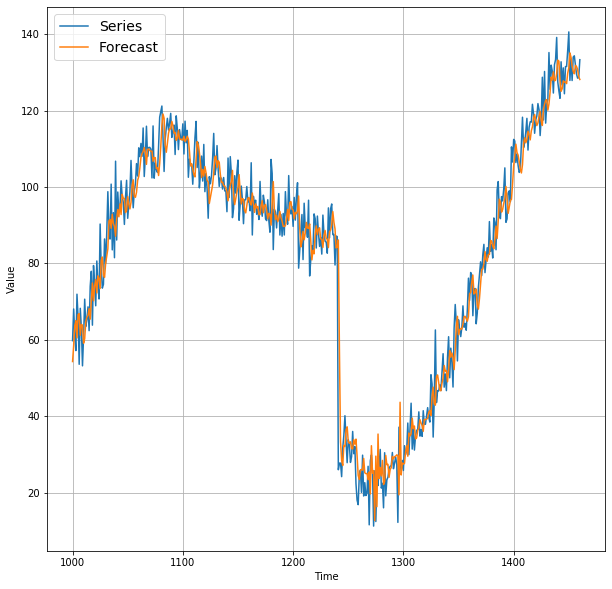

In [11]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,rnn_forecast,label="Forecast")

keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()
# MAE is still 5.05